In [28]:
%pip install pycocotools #our annotations are in coco json



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
# helpful sources for COCO: https://www.v7labs.com/blog/coco-dataset-guide
# https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/md-coco-overview.html
# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
from pycocotools.coco import COCO
import os
annotation_file = '../Annotations/combined_annotations.coco.json'
coco = COCO(annotation_file)
#now I have to make sure I get the ID for each and every image
image_ids = coco.getImgIds()
images = coco.loadImgs(image_ids)

#preping image data for keras:
for img in images: #iterating over each image in list of images from COCO dataset
    image_id = img['id'] # 'id' is the unique image identifier
    file_name = img['file_name'] #image's file name
    
    annotation_ids = coco.getAnnIds(imgIds=image_id) #this gets the annotation ID"s associated with the given image in the for loop
    the_annotations = coco.loadAnns(annotation_ids)  #loadAnns retrieves annotation data as a LIST of dictionaries
        #each dict includes data on the image like bounding box (bbox)
        
    bboxes = [ann['bbox'] for ann in the_annotations]
    
    #print(bboxes)  ok we have a lot of different numbers here
    

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [30]:
#now I just want to check the total number of images we have
import os
image_dir = '../Image_data/DS 4002 Project 3 raw image data'
# get a simple list of all files
all_files = os.listdir(image_dir)
# Filter out non-image files incase i skrewed something up
image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

num_images = len(image_files) #this gives the total count of images we have
print(f'Total number of images: {num_images}')
print("great, we have 1601 images in our repo!")



Total number of images: 1601
great, we have 1601 images in our repo!


In [31]:
#ok, now I'll split our data into an 20/80 train/test split using sklearn
import sklearn.model_selection
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)
print(f'Number of training images: {len(train_files)}')
print(f'Number of validation images: {len(val_files)}')

Number of training images: 1280
Number of validation images: 321


In [32]:


#next I'm going to use cv2, which is helpful for doing things like image resizing
#source: https://konfuzio.com/en/cv2/#:~:text=The%20cv2%20module%20is%20the,commonly%20used%20functions%20in%20cv2.
%pip install opencv-python-headless
import cv2
import numpy as np
import matplotlib.pyplot as plt
#I will start by initializing each images' width and height in a list
widths = []
heights = []

for file in image_files:
    image_path = os.path.join(image_dir, file) #make sure paths are consistent across systems, in case this is replicated elsewhere
        #again, this is image_dir: image_dir = '../Image_data/DS 4002 Project 3 raw image data'
    image = cv2.imread(image_path) 
        #print(image) --> did this to check, this is a 3 element list of info abt each image
    h, w = image.shape[:2]  #for each image we get height and width, the :2 is to extract only these first two elements
    widths.append(w)  # Add width to the list
    heights.append(h)  # Add height to the list

widths = np.array(widths)
heights = np.array(heights)

print(f"Testing first 10 widths and heights. \n Widths: {widths[:10]}, \n Heights: {heights[:10]}")
print(f"length of each. Length Widths: {len(widths)}, Length of Heights: {len(heights)}")
#ok sweet looks like everything is working thusfar. We now have the pixel widths and height for every image



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Testing first 10 widths and heights. 
 Widths: [612 262 612 612 800 480 480 600 275 612], 
 Heights: [408 192 408 409 533 270 320 424 183 370]
length of each. Length Widths: 1601, Length of Heights: 1601


In [33]:
#now i'll make a histogram including the sizes of the images

import os
import matplotlib.pyplot as plt

# Define the path to the outputs folder
output_dir = '../Output'

# Plot histograms of image widths and heights
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()

# Save the histogram to the outputs folder
output_path = os.path.join(output_dir, 'image_sizes_histogram.png')
plt.savefig(output_path)  # Save the plot as a PNG file
plt.close()  # Close the plot to free memory

print(f"Histogram is visibile Output folder")


Histogram is visibile Output folder


In [34]:
#now for some basic statistics on the images
from scipy import stats

mode_width = int(stats.mode(widths)[0])
mode_height = int(stats.mode(heights)[0])
print(f"The Mode dimensions respectively: {mode_width}, {mode_height}")

print("\n")
avg_pxl_width = int(np.mean(widths))
avg_pxl_height = int(np.mean(heights))
print(f"the average dimensions of an image in our dataset is: \n{avg_pxl_width}, {avg_pxl_height}")


The Mode dimensions respectively: 612, 408


the average dimensions of an image in our dataset is: 
616, 454


In [35]:
#Now at last I can resize the images so that they are ready to use in keras

end_goal_size_of_image = (mode_width, mode_height)
# Rational: I'd like to change the fewest images as possible to minimize distortion.

def change_image_dimensions(a_file, size, origin_directory, end_directory):
    """
    This function resizes images to the desired dimensions for consistency 
    when performing object recognition with Keras.
    It is possible that resizing may not be ideal, but it ensures all images are uniform.
    """
    image_path = os.path.join(origin_directory, a_file)
    image = cv2.imread(image_path)
    
    if image is None:  # THIS WAS NECESSARY - some images may not load, preventing resizing
        print(f"Could not load image: {image_path}")
        return  # Skip the current image and move to the next

    resized_image = cv2.resize(image, size) # Resize the image to the specified size (e.g., mode or mean dimensions)
    end_path = os.path.join(end_directory, a_file) # Construct the path to save the resized image
    

    # Save the resized image to the specified directory
    cv2.imwrite(end_path, resized_image)
    print(f"Resized image saved to: {end_path}")



In [36]:
#really quickly, I'm going to clear the target directories 
# to make sure there are no residuals from my old tries at doing this
#source: https://docs.python.org/3/library/shutil.html

import shutil
shutil.rmtree(new_train_directory, ignore_errors=True)
shutil.rmtree(new_val_directory, ignore_errors=True)
os.makedirs(new_train_directory, exist_ok=True)
os.makedirs(new_val_directory, exist_ok=True)

NameError: name 'new_train_directory' is not defined

In [ ]:
#now i will use our function to resize everything
#and then send it over to a new resized directory

new_train_directory = "../Resized_image_data/Training"
new_val_directory = "../Resized_image_data/Valid"

#for reference: image_dir = '../Image_data/DS 4002 Project 3 raw image data'
for file in train_files: #using images we already split int train/val
    change_image_dimensions(file, end_goal_size_of_image, image_dir, new_train_directory)
    
for file in val_files: #using the files we already split into train/val
    change_image_dimensions(file, end_goal_size_of_image, image_dir, new_val_directory)



Resized image saved to: ../Resized_image_data/Training/s_126_jpg.rf.b5f09d9ca3a2819f64a45aa42ed6b860.jpg
Resized image saved to: ../Resized_image_data/Training/c_32_jpg.rf.b243e382ac45f74f6e2ea59d693502a9.jpg
Resized image saved to: ../Resized_image_data/Training/c_526_jpg.rf.7d64c22e0b69b818fc1c71fbd993d335.jpg
Resized image saved to: ../Resized_image_data/Training/istockphoto-1264517767-612x612_jpeg.rf.693dc6dea95ac1979cdb9e0f2bd5e41e.jpg
Resized image saved to: ../Resized_image_data/Training/s_567_jpg.rf.97f603a8a1aa49b4129fa46be2277738.jpg
Resized image saved to: ../Resized_image_data/Training/kuala-lumpur-malaysia-november-29-600w-1243774912_jpg.rf.34bbe6fca395ec92811100554f2b14b9.jpg
Resized image saved to: ../Resized_image_data/Training/istockphoto-496648915-612x612_jpg.rf.9cc52d0227e12b33cf83bf1c34e740f0.jpg
Resized image saved to: ../Resized_image_data/Training/gettyimages-1346129989-612x612_jpg.rf.97ed36a1ce9f4334b9d74a00a4091bb5.jpg
Resized image saved to: ../Resized_image_d

Resized image saved to: ../Resized_image_data/Training/istockphoto-170462659-612x612_jpeg.rf.6d65e3fab31393b09916ed03f6271f43.jpg
Resized image saved to: ../Resized_image_data/Training/gettyimages-1301775398-612x612_jpg.rf.d0cf9b4f61f5d339191981c0fc43dab6.jpg
Resized image saved to: ../Resized_image_data/Training/gettyimages-1314222823-612x612_jpg.rf.f7c8880013ec8bd6f2564293dee72bce.jpg
Resized image saved to: ../Resized_image_data/Training/74_jpg.rf.018cf7a2caa28eda9035ad6cb4af2add.jpg
Resized image saved to: ../Resized_image_data/Training/woman-in-wheelchair-using-access-ramp-in-pavement-at-pedestrian-crossing-F7AWCM_jpeg.rf.9253c01c4cabe595b71825265aded823.jpg
Resized image saved to: ../Resized_image_data/Training/c_347_jpg.rf.480209dbdf884e1edcccc6f1890698fe.jpg
Resized image saved to: ../Resized_image_data/Training/c_318_jpg.rf.aa7fd7daef19ff111637360a3c72ddd8.jpg
Resized image saved to: ../Resized_image_data/Training/senior-man-woman-rollator-early-spring-sunny-day-germany-213836

In [ ]:
#and now just to check that the training and valid folders recieved the files
# Specify the folder path
folder_path1 = new_train_directory
folder_path2 = new_val_directory


file_count1 = len(os.listdir(folder_path1))
file_count2 = len(os.listdir(folder_path2))

print(f"The number of images in Training folder is: {file_count1}")
print(f"The number of images in Valid folder is: {file_count2}")


print(f"And for reference, here is the number of images *before* resizing to see if anything is lost")
print(f'Number of training images: {len(train_files)}')
print(f'Number of validation images: {len(val_files)}')

The number of images in Training folder is: 1280
The number of images in Valid folder is: 321
And for reference, here is the number of images *before* resizing to see if anything is lost
Number of training images: 1280
Number of validation images: 321


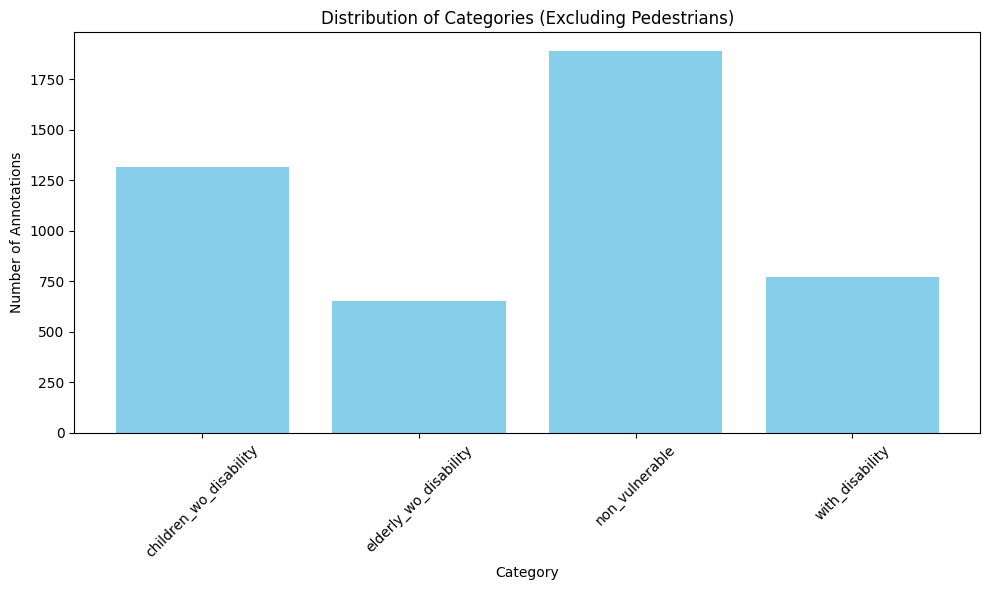

In [ ]:
#now to do some visualizations using the JSON annotations
import json
import matplotlib.pyplot as plt

file_path = '../Annotations/combined_annotations.coco.json'
with open(file_path, 'r') as f:
    coco_data = json.load(f)

#this obtains category names and their corresponding IDs, excluding 'pedestrians'
categories = [cat for cat in coco_data['categories'] if cat['name'].lower() != 'pedestrians']
category_dict = {cat['id']: cat['name'] for cat in categories}

#this counts annotations per category selected
annotation_counts = {cat['name']: 0 for cat in categories}
for annotation in coco_data['annotations']:
    category_id = annotation['category_id']
    if category_id in category_dict:
        category_name = category_dict[category_id]
        annotation_counts[category_name] += 1


plt.figure(figsize=(10, 6))
plt.bar(annotation_counts.keys(), annotation_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title('Distribution of Categories (Excluding Pedestrians)')
plt.xlabel('Category')
plt.ylabel('Number of Annotations')
plt.tight_layout()
plt.show()


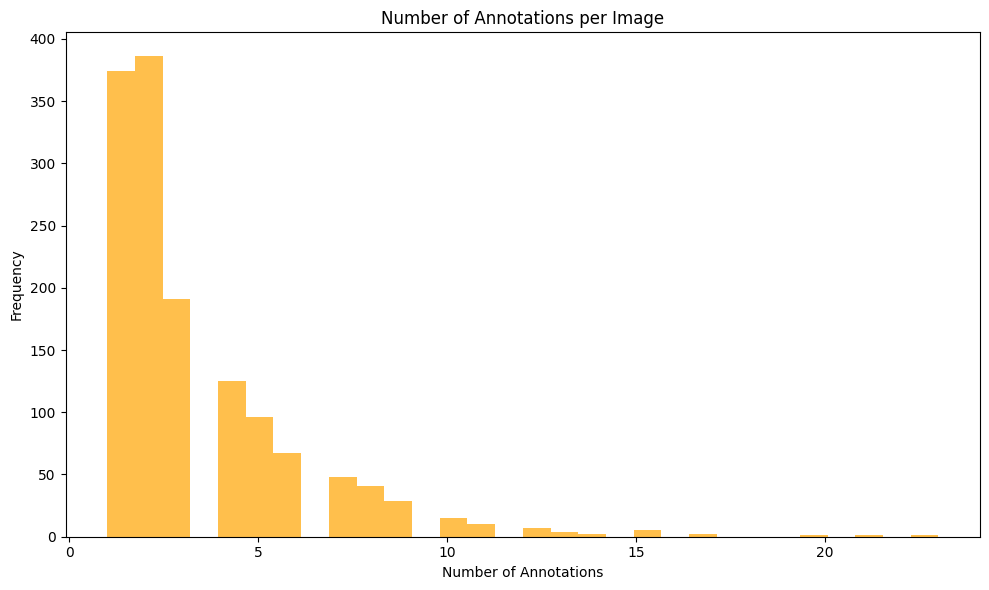

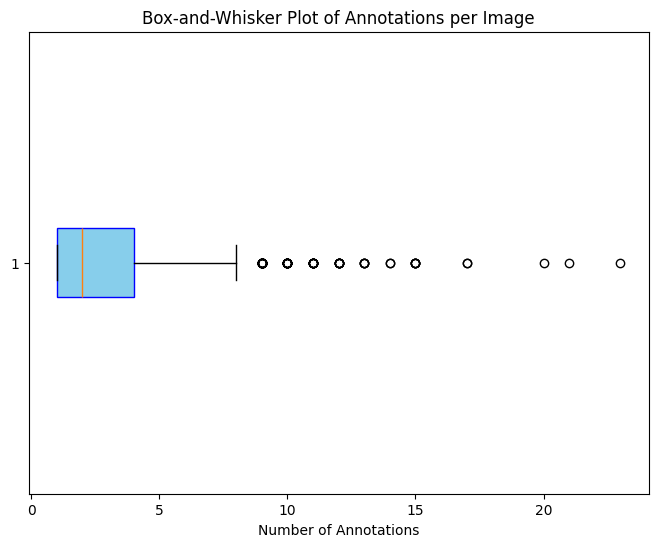

Mean annotations per image = 3.290391459074733
St. Dev annotations per image = 2.724469718222437
Median annotations per image = 2
Max annotations in an image = 23
Number of images with annotations > [mean + stdev] = 166
Count of total annotations from images containing greater than > [mean + stdev] annotations = 1522


Number of images with annotations > 3*[mean + stdev] = 23
Count of total annotations from images containing greater than > 3*[mean + stdev] annotations = 337
Altogether there are 23 outliers in the dataset


In [ ]:
#this visualization just shows annotations per image
with open('../Annotations/combined_annotations.coco.json', 'r') as f:
    coco_data = json.load(f)

annotations = coco_data['annotations']
image_annotation_counts = {}

#Just finding annotations counts for each inidivual image.
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id not in image_annotation_counts:
        image_annotation_counts[image_id] = 0
    image_annotation_counts[image_id] += 1


annotation_counts_list = list(image_annotation_counts.values())
plt.figure(figsize=(10, 6))
plt.hist(annotation_counts_list, bins=30, color='orange', alpha=0.7)
plt.title('Number of Annotations per Image')
plt.xlabel('Number of Annotations')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#box and whisker plots to help generally percieve outliers
plt.figure(figsize=(8, 6))
plt.boxplot(annotation_counts_list, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue', color='blue'))
plt.title('Box-and-Whisker Plot of Annotations per Image')
plt.xlabel('Number of Annotations')
plt.show()


#now to just get some basic statistics

import statistics

print(f"Mean annotations per image = {statistics.mean(annotation_counts_list)}")
print(f"St. Dev annotations per image = {statistics.stdev(annotation_counts_list)}")
print(f"Median annotations per image = {statistics.median(annotation_counts_list)}")
print(f"Max annotations in an image = {max(annotation_counts_list)}")

count = 0
numb_of_ann = 0
for numbs in annotation_counts_list:
    if numbs > (statistics.mean(annotation_counts_list) + statistics.stdev(annotation_counts_list)):
        count += 1
        numb_of_ann += numbs
        
#I'm curious to guage the impact of the higher annotations and outliers:
print(f"Number of images with annotations > [mean + stdev] = {count}")
print(f"Count of total annotations from images containing greater than > [mean + stdev] annotations = {numb_of_ann}")
print("\n")




#now for true outliers
count2 = 0
numb_of_ann2 = 0
for numbs in annotation_counts_list:
    if numbs > (statistics.mean(annotation_counts_list) + 3*statistics.stdev(annotation_counts_list)):
        count2 += 1
        numb_of_ann2 += numbs
        
print(f"Number of images with annotations > 3*[mean + stdev] = {count2}")
print(f"Count of total annotations from images containing greater than > 3*[mean + stdev] annotations = {numb_of_ann2}")
print(f"Altogether there are {count2} true outliers in the dataset")


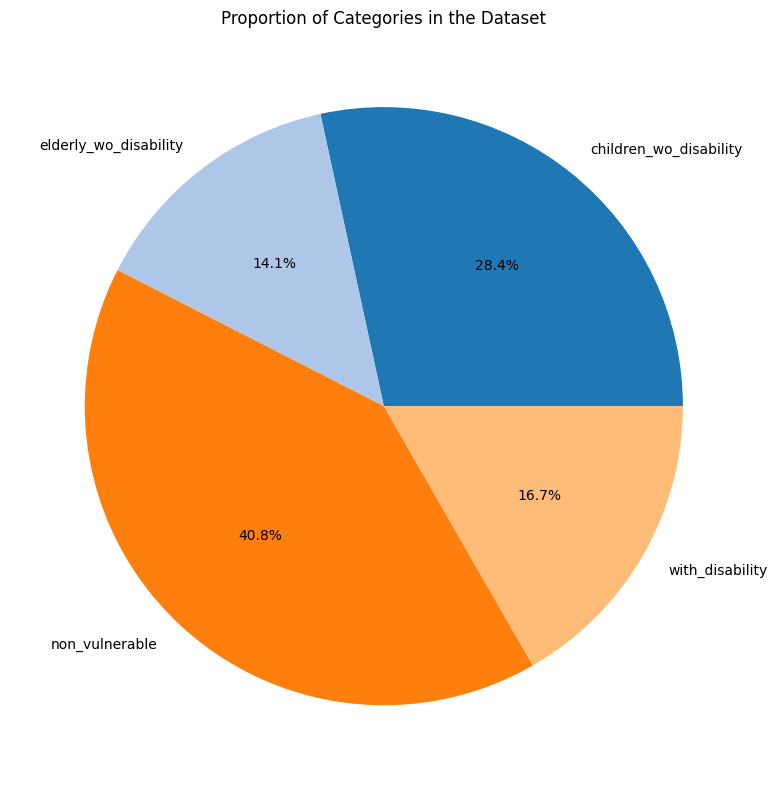

In [ ]:
#This is simply the percentage of categories
total_annotations = sum(annotation_counts.values())
category_proportions = {cat: count / total_annotations for cat, count in annotation_counts.items()}

#pie chart ahead
plt.figure(figsize=(10, 8))
plt.pie(category_proportions.values(), labels=category_proportions.keys(), autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title('Proportion of Categories in the Dataset')
plt.tight_layout()
plt.show()
